<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [410]:
# Import torch
import torch
import torchmetrics

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}")

# Setup random seed
RANDOM_SEED = 42

cpu


## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [411]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X_moons_array, y_moons_array = make_moons(1000)

In [412]:
# Turn data into a DataFrame
import pandas as pd
df_moons = pd.DataFrame(X_moons_array)
df_moons['Target'] = y_moons_array

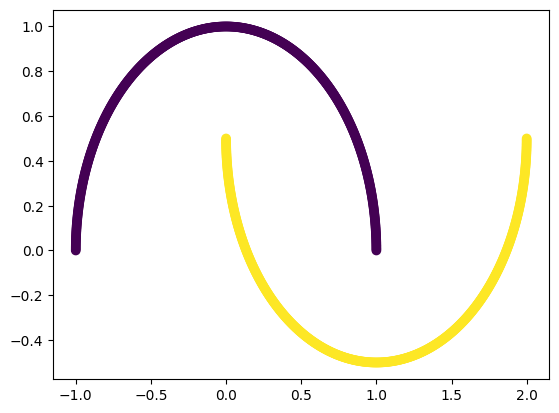

In [413]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(df_moons.iloc[:,0],df_moons.iloc[:,1], c=y_moons_array)

In [414]:
# Turn data into tensors of dtype float
X_moons = torch.from_numpy(X_moons_array).type(torch.float32)
y_moons = torch.from_numpy(y_moons_array).type(torch.float32)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, test_size = 0.2, random_state = 42)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [415]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self):
      super().__init__()
      self.neural_network = nn.Sequential(
          nn.Linear(in_features = 2, out_features = 16),
          nn.ReLU(),
          nn.Linear(in_features = 16, out_features = 32),
          nn.ReLU(),
          nn.Linear(in_features = 32, out_features = 1),
          nn.Sigmoid()
      )

    def forward(self, x):
      return  self.neural_network(x)

# Instantiate the model
model_v0 = MoonModelV0()

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [416]:
# Setup loss function
loss_fn = nn.BCELoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(model_v0.parameters(), lr = 0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [417]:
# What's coming out of our model?
epochs = 600
accuracy = torchmetrics.Accuracy(task="binary")

for epoch in range(epochs):
  model_v0.train()
  y_pred = model_v0(X_moons_train).squeeze()
  loss = loss_fn(y_pred, y_moons_train)
  if epoch % 50 == 0:
    print(f"Epoch: {epoch}  |  Accuracy Train = {accuracy(y_moons_train, torch.round(y_pred))}")
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_v0.eval()
  with torch.inference_mode():
    y_test_pred = model_v0(X_moons_test).squeeze()
    if epoch % 50 == 0:
      print(f"Epoch: {epoch}  |  Accuracy Test = {accuracy(y_moons_test, torch.round(y_test_pred))}")


Epoch: 0  |  Accuracy Train = 0.7649999856948853
Epoch: 0  |  Accuracy Test = 0.7250000238418579
Epoch: 50  |  Accuracy Train = 0.800000011920929
Epoch: 50  |  Accuracy Test = 0.7699999809265137
Epoch: 100  |  Accuracy Train = 0.8575000166893005
Epoch: 100  |  Accuracy Test = 0.824999988079071
Epoch: 150  |  Accuracy Train = 0.8912500143051147
Epoch: 150  |  Accuracy Test = 0.8700000047683716
Epoch: 200  |  Accuracy Train = 0.9087499976158142
Epoch: 200  |  Accuracy Test = 0.8949999809265137
Epoch: 250  |  Accuracy Train = 0.9212499856948853
Epoch: 250  |  Accuracy Test = 0.9100000262260437
Epoch: 300  |  Accuracy Train = 0.9350000023841858
Epoch: 300  |  Accuracy Test = 0.9200000166893005
Epoch: 350  |  Accuracy Train = 0.9462500214576721
Epoch: 350  |  Accuracy Test = 0.9350000023841858
Epoch: 400  |  Accuracy Train = 0.9574999809265137
Epoch: 400  |  Accuracy Test = 0.9549999833106995
Epoch: 450  |  Accuracy Train = 0.9700000286102295
Epoch: 450  |  Accuracy Test = 0.970000028610229

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [418]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(y_logits) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

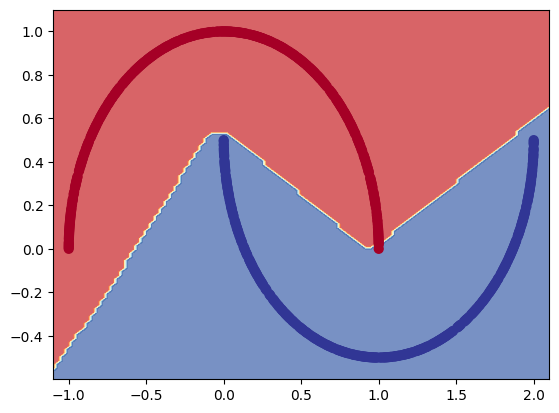

In [419]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_v0, X_moons_train, y_moons_train)

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

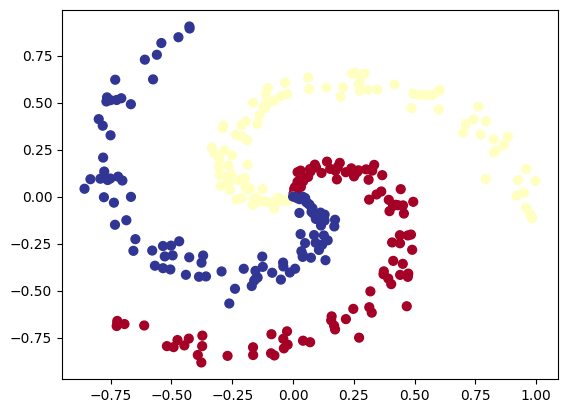

In [420]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [421]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [422]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [423]:
# Prepare device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module

class Model_v1(nn.Module):
  def __init__(self):
    super().__init__()
    self.neural_network = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 64),
        nn.ReLU(),
        nn.Linear(in_features = 64, out_features = 64),
        nn.ReLU(),
        nn.Linear(in_features = 64, out_features = 3),
        #nn.Softmax(dim=1)     # better to leave it outside, so I can use a comfortable Loss Function
    )
  def forward(self,x):
    return self.neural_network(x)

# Instantiate model and send it to device
model_v1 = Model_v1()

In [424]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v1.parameters(), lr = 0.1)

In [425]:
# Build a training loop for the model

# Loop over data
epochs = 1000
for epoch in range(epochs):
  model_v1.train()
  y_logits = model_v1(X_train)
  loss = loss_fn(y_logits, y_train)
  if epoch % 50 == 0:
   print(f"Epoch: {epoch}  |  Accuracy Train = {acc_fn(y_train, torch.softmax(y_logits, dim = 1).argmax(dim=1))}")

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_v1.eval()
  y_logits_test = model_v1(X_test)
  if epoch % 50 == 0:
   print(f"Epoch: {epoch}  |  Accuracy test = {acc_fn(y_test, torch.softmax(y_logits_test, dim = 1).argmax(dim=1))}")


Epoch: 0  |  Accuracy Train = 0.3499999940395355
Epoch: 0  |  Accuracy test = 0.2666666805744171
Epoch: 50  |  Accuracy Train = 0.5333333611488342
Epoch: 50  |  Accuracy test = 0.5166666507720947
Epoch: 100  |  Accuracy Train = 0.5458333492279053
Epoch: 100  |  Accuracy test = 0.5
Epoch: 150  |  Accuracy Train = 0.574999988079071
Epoch: 150  |  Accuracy test = 0.5166666507720947
Epoch: 200  |  Accuracy Train = 0.6083333492279053
Epoch: 200  |  Accuracy test = 0.550000011920929
Epoch: 250  |  Accuracy Train = 0.6499999761581421
Epoch: 250  |  Accuracy test = 0.6166666746139526
Epoch: 300  |  Accuracy Train = 0.699999988079071
Epoch: 300  |  Accuracy test = 0.6833333373069763
Epoch: 350  |  Accuracy Train = 0.737500011920929
Epoch: 350  |  Accuracy test = 0.75
Epoch: 400  |  Accuracy Train = 0.7916666865348816
Epoch: 400  |  Accuracy test = 0.800000011920929
Epoch: 450  |  Accuracy Train = 0.8291666507720947
Epoch: 450  |  Accuracy test = 0.8166666626930237
Epoch: 500  |  Accuracy Train 

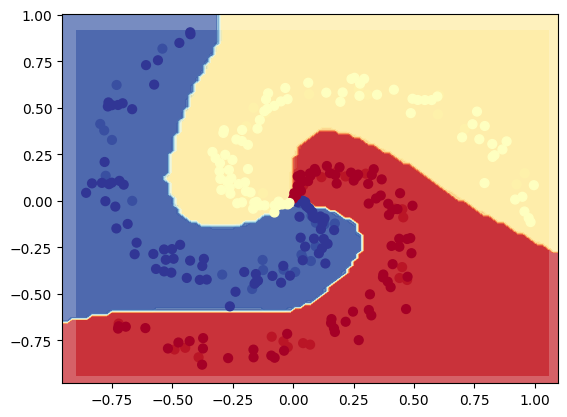

In [426]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_v1, X_test, y_test)
plot_decision_boundary(model_v1, X_train, y_train)